In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# about data

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
# Nan values
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
train_df['target'].unique()

array([1, 0])

In [13]:
train_df.groupby('target').count()

,id,keyword,location,text
target,,,,
0,4342,4323,2884,4342
1,3271,3229,2196,3271


In [9]:
train_df['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [10]:
train_df['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

# EDA and feature engineering

In [14]:
train_df['has_location'] = train_df['location'].notnull().astype('int')
train_df['has_keyword'] = train_df['keyword'].notnull().astype('int')
train_df['text_len'] = train_df['text'].apply(lambda x: len(x))

In [16]:
train_df.groupby('has_location')['target'].mean()

has_location
0    0.424398
1    0.432283
Name: target, dtype: float64

In [17]:
train_df.groupby('has_keyword')['target'].mean()

has_keyword
0    0.688525
1    0.427569
Name: target, dtype: float64

In [18]:
train_df.groupby('target')['text_len'].mean()

target
0     95.706817
1    108.113421
Name: text_len, dtype: float64

In [20]:
train_df.groupby('target')['text_len'].median()

target
0    101.0
1    115.0
Name: text_len, dtype: float64

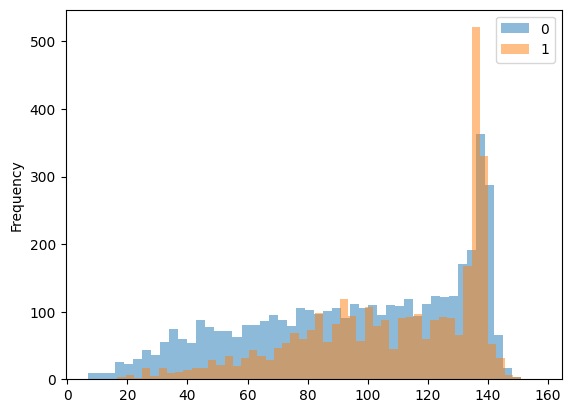

In [23]:
train_df.groupby('target')['text_len'].plot(kind='hist', alpha=0.5, bins=50)
plt.legend(['0', '1'])

In [24]:
# test data
test_df['has_location'] = test_df['location'].notnull().astype('int')
test_df['has_keyword'] = test_df['keyword'].notnull().astype('int')
test_df['text_len'] = test_df['text'].apply(lambda x: len(x))

# Modeling
1. simple feature model (lightGBM)
2. tf-idf model (lightGBM)
3. sentence-BERT embedding (lightGBM)
4. fine-tuning (BERT)

In [27]:
# model with simple features (lightgbm)
# split train_df into train and validation
X_simple = train_df[['has_location', 'has_keyword', 'text_len']]
y_simple = train_df['target']
X_train_simple, X_val_simple, y_train_simple, y_val_simple = train_test_split(X_simple, y_simple, test_size=0.2, random_state=42)

# train model
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score

lgb_train_simple = lgb.Dataset(X_train_simple, y_train_simple)
lgb_val_simple = lgb.Dataset(X_val_simple, y_val_simple)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

model_simple = lgb.train(
    params,
    lgb_train_simple,
    valid_sets=[lgb_train_simple, lgb_val_simple],
    num_boost_round=1000
)

# predict
y_pred_simple = model_simple.predict(X_val_simple)
y_pred_simple = np.round(y_pred_simple)

# evaluate
print(accuracy_score(y_val_simple, y_pred_simple))
print(f1_score(y_val_simple, y_pred_simple))
print(classification_report(y_val_simple, y_pred_simple))

0.5909389363099147
0.45684394071490847
              precision    recall  f1-score   support

           0       0.62      0.73      0.67       874
           1       0.53      0.40      0.46       649

    accuracy                           0.59      1523
   macro avg       0.57      0.57      0.56      1523
weighted avg       0.58      0.59      0.58      1523



In [28]:
# model with tf-idf (lightgbm)
# split train_df into train and validation
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(train_df['text'])
y_text = train_df['target']
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(X_text, y_text, test_size=0.2, random_state=42)

# train model
lgb_train_text = lgb.Dataset(X_train_text, y_train_text)
lgb_val_text = lgb.Dataset(X_val_text, y_val_text)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

model_text = lgb.train(
    params,
    lgb_train_text,
    valid_sets=[lgb_train_text, lgb_val_text],
    num_boost_round=1000
)

# predict
y_pred_text = model_text.predict(X_val_text)
y_pred_text = np.round(y_pred_text)

# evaluate
print(accuracy_score(y_val_text, y_pred_text))
print(f1_score(y_val_text, y_pred_text))
print(classification_report(y_val_text, y_pred_text))


0.7590282337491793
0.7094220110847188
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       874
           1       0.73      0.69      0.71       649

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



In [139]:
# sentence-BERT model from huggingface
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

# encode text
X_text = train_df['text'].tolist()
X_text = model.encode(X_text)

# split train_df into train and validation
y_text = train_df['target']
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(X_text, y_text, test_size=0.2, random_state=42)

# train model
lgb_train_text = lgb.Dataset(X_train_text, y_train_text)
lgb_val_text = lgb.Dataset(X_val_text, y_val_text)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

model_text = lgb.train(
    params,
    lgb_train_text,
    valid_sets=[lgb_train_text, lgb_val_text],
    num_boost_round=1000
)

# predict
y_pred_text = model_text.predict(X_val_text)
y_pred_text = np.round(y_pred_text)

# evaluate
print(accuracy_score(y_val_text, y_pred_text))
print(f1_score(y_val_text, y_pred_text))
print(classification_report(y_val_text, y_pred_text))

0.8181221273801708
0.7757085020242914
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       874
           1       0.82      0.74      0.78       649

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



In [118]:
max_len = train_df['text_len'].max()

In [124]:
# fine-tune BERT model from huggingface
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# split train_df into train and validation
X_text = train_df['text'].values
y_text = train_df['target'].values

X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(X_text, y_text, test_size=0.2, random_state=42)

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [126]:
def convert_to_input(texts, labels):
    input_ids = []
    attention_masks = []

    # For every tweet...
    for tweet in texts:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            tweet,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    # Combine the training inputs into a TensorDataset.
    dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

# convert to input
train_dataset = convert_to_input(X_train_text, y_train_text)
val_dataset = convert_to_input(X_val_text, y_val_text)
test_dataset = convert_to_input(test_df['text'].values, np.zeros(test_df.shape[0]))

/Users/kiro02/Library/Caches/pypoetry/virtualenvs/cub-2023oct-tIHWYxGD-py3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [128]:
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# for test data
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [132]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

device = torch.device("mps")
model = model.to(device)

model.safetensors: 100%|██████████| 440M/440M [00:20<00:00, 22.0MB/s] 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [133]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/Users/kiro02/Library/Caches/pypoetry/virtualenvs/cub-2023oct-tIHWYxGD-py3.11/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [134]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [136]:
import random
import numpy as np
import time
import datetime

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)        
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'bert_model')
        best_eval_accuracy = avg_val_accuracy
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.63
  Training epcoh took: 0:03:27

Running Validation...
  Accuracy: 0.66

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.58
  Training epcoh took: 0:03:25

Running Validation...
  Accuracy: 0.73

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.51
  Training epcoh took: 0:03:27

Running Validation...
  Accuracy: 0.73

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.48
  Training epcoh took: 0:03:22

Running Validation...
  Accuracy: 0.73

Training complete!
Total training took 0:14:45 (h:mm:ss)


# Conclusion

In [151]:
# predict on test data by lightgbm
vectorizer = SentenceTransformer('bert-base-nli-mean-tokens')

test_vector = vectorizer.encode(test_df['text'])
y_pred_text = model_text.predict(test_vector)

In [154]:
y_pred_text.shape

(3263,)

In [155]:
test_df['label'] = y_pred_text

In [156]:
test_df[['id', 'label']].rename(
    columns={'id': 'id', 'label': 'target'}
).to_csv('submission.csv', index=False)